ФИО: Салихова Кария Илшатовна

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [0]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [0]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw


Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [0]:
len(dataloader)

3750

In [0]:
for image, cat in dataloader:
    break

In [0]:
image.size()

torch.Size([16, 1, 28, 28])

In [0]:
28*28

784

### Create generator and discriminator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [0]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [0]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [0]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [0]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch:1 Iter: 100 errD_x: 0.19 errD_z: 0.16 errG: 1.94
Epoch:1 Iter: 200 errD_x: 0.31 errD_z: 0.19 errG: 2.09
Epoch:1 Iter: 300 errD_x: 0.23 errD_z: 0.15 errG: 2.18
Epoch:1 Iter: 400 errD_x: 0.05 errD_z: 0.10 errG: 2.56
Epoch:1 Iter: 500 errD_x: 0.34 errD_z: 0.09 errG: 2.54
Epoch:1 Iter: 600 errD_x: 0.02 errD_z: 0.08 errG: 2.76
Epoch:1 Iter: 700 errD_x: 0.18 errD_z: 0.20 errG: 2.02
Epoch:1 Iter: 800 errD_x: 0.07 errD_z: 0.14 errG: 2.38
Epoch:1 Iter: 900 errD_x: 0.34 errD_z: 0.14 errG: 2.09
Epoch:1 Iter: 1000 errD_x: 0.34 errD_z: 0.19 errG: 1.98
Epoch:1 Iter: 1100 errD_x: 0.07 errD_z: 0.20 errG: 2.05
Epoch:1 Iter: 1200 errD_x: 0.38 errD_z: 0.17 errG: 2.02
Epoch:1 Iter: 1300 errD_x: 0.26 errD_z: 0.33 errG: 1.79
Epoch:1 Iter: 1400 errD_x: 0.26 errD_z: 0.41 errG: 1.61
Epoch:1 Iter: 1500 errD_x: 0.10 errD_z: 0.21 errG: 2.04
Epoch:1 Iter: 1600 errD_x: 0.15 errD_z: 0.15 errG: 2.31
Epoch:1 Iter: 1700 errD_x: 0.13 errD_z: 0.20 errG: 2.28
Epoch:1 Iter: 1800 errD_x: 0.07 errD_z: 0.25 errG: 2.07
E

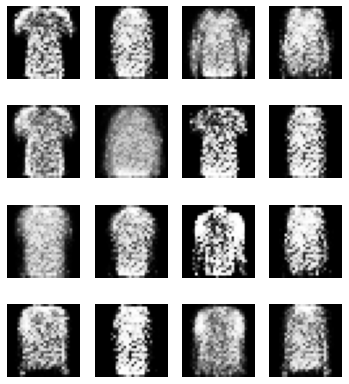

In [0]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

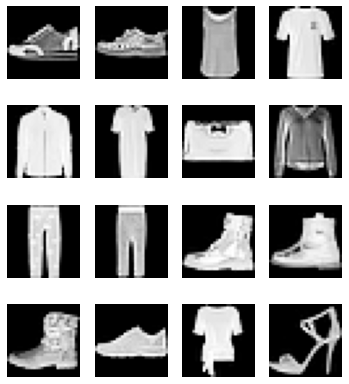

In [0]:
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

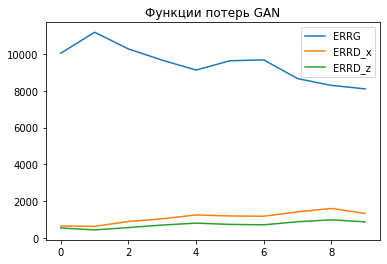

In [0]:
plt.plot(ERRG, label = "ERRG")
plt.plot(ERRD_x, label = "ERRD_x")
plt.plot(ERRD_z, label = "ERRD_z")
plt.legend()
plt.title("Функции потерь GAN")
plt.show()

# 1. Интерполяция


Идея из книги: Jason Brownlee "Deep Learning Generative Models for Image Synthesis and Image Translation"

In [0]:
from numpy.random import randn

In [0]:
def interpolate_points(p1, p2, n_steps=10):
  ratios = np.linspace(0, 1, num=n_steps)
  vectors = []
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  return np.array(vectors)

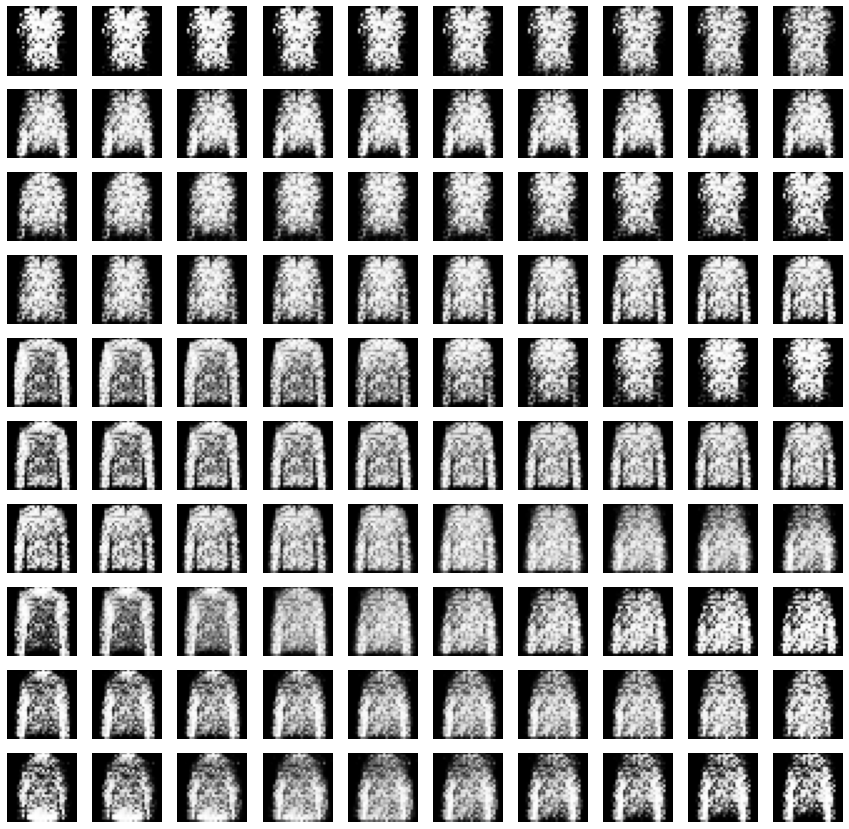

In [0]:
k = 10
noise.data.normal_(0, 1)
x_input = randn(config.noise_size * 2*k)
z_input = x_input.reshape(2*k, config.noise_size)
results = None
for i in range(0, 2*k, 2):
  interpolated = interpolate_points(z_input[i], z_input[i+1])
  X = generator(torch.FloatTensor(interpolated))
  if results is None:
    results = X.detach().numpy()
  else:
    results = np.vstack((results, X.detach().numpy()))

plt.figure(figsize=(15, 15))
for i in range(k*k):
  plt.subplot(k, k, 1 + i)
  plt.imshow(results[i].reshape(28, 28), cmap=plt.cm.Greys_r)
  plt.axis('off')
plt.show()

Попробовала реализовать DCGAN по статье, но с размерностями так и не получилось договориться :(

In [0]:
class DCGenerator(nn.Module):
    def __init__(self):
        super(DCGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(config.noise_size, 28 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(28 * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(28 * 8, 28 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 28 * 4, 28 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 28 * 2, 28, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 28, 1, 4, 2, 1, bias=False),
            nn.Tanh())
        
    def forward(self, x):
        return self.model(x)
    
class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 28, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(28, 28 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(28 * 2, 28 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(28 * 4, 28 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(28 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

# 2. LSGAN


In [0]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

In [0]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [0]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize (D(x) - 1)^2 + (D(G(z)))^2 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize (D(G(x) - 1))^2
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:1 Iter: 100 errD_x: 0.51 errD_z: 0.03 errG: 0.80
Epoch:1 Iter: 200 errD_x: 0.55 errD_z: 0.02 errG: 0.93
Epoch:1 Iter: 300 errD_x: 0.38 errD_z: 0.00 errG: 0.98
Epoch:1 Iter: 400 errD_x: 0.55 errD_z: 0.02 errG: 0.94
Epoch:1 Iter: 500 errD_x: 0.10 errD_z: 0.13 errG: 0.68
Epoch:1 Iter: 600 errD_x: 0.20 errD_z: 0.00 errG: 0.95
Epoch:1 Iter: 700 errD_x: 0.37 errD_z: 0.05 errG: 0.87
Epoch:1 Iter: 800 errD_x: 0.37 errD_z: 0.01 errG: 0.96
Epoch:1 Iter: 900 errD_x: 0.68 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1000 errD_x: 0.53 errD_z: 0.05 errG: 0.94
Epoch:1 Iter: 1100 errD_x: 0.62 errD_z: 0.00 errG: 0.99
Epoch:1 Iter: 1200 errD_x: 0.37 errD_z: 0.00 errG: 0.98
Epoch:1 Iter: 1300 errD_x: 0.40 errD_z: 0.03 errG: 0.95
Epoch:1 Iter: 1400 errD_x: 0.43 errD_z: 0.00 errG: 0.99
Epoch:1 Iter: 1500 errD_x: 0.31 errD_z: 0.15 errG: 0.64
Epoch:1 Iter: 1600 errD_x: 0.43 errD_z: 0.00 errG: 0.97
Epoch:1 Iter: 1700 errD_x: 0.32 errD_z: 0.00 errG: 0.93
Epoch:1 Iter: 1800 errD_x: 0.21 errD_z: 0.02 errG: 0.83
E

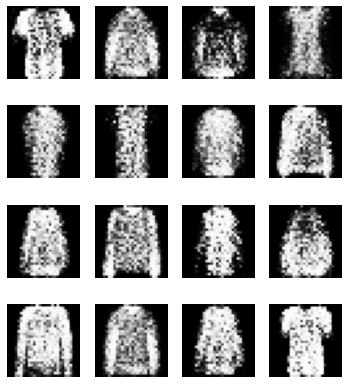

In [0]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

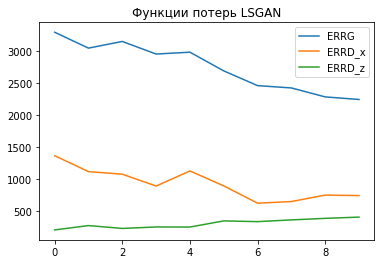

In [0]:
plt.plot(ERRG, label = "ERRG")
plt.plot(ERRD_x, label = "ERRD_x")
plt.plot(ERRD_z, label = "ERRD_z")
plt.legend()
plt.title("Функции потерь LSGAN")
plt.show()

# 3. Conditional GAN

In [0]:
class ConditionalGenerator(nn.Module):
  def __init__(self):
    super(ConditionalGenerator, self).__init__()
    self.label_emb = nn.Embedding(10, 10)
    self.model = nn.Sequential(
        nn.Linear(config.noise_size+10, 200),
        nn.ReLU(inplace=True),
        nn.Linear(200, 784),
        nn.Sigmoid()
        )
    
  def forward(self, z, labels):
    c = self.label_emb(labels)
    x = torch.cat([z, c], 1)
    return self.model(x)

In [0]:
class ConditionalDiscriminator(nn.Module):
  def __init__(self):
    super(ConditionalDiscriminator, self).__init__() 
    self.label_emb = nn.Embedding(10, 10)
    self.model = nn.Sequential(
        nn.Linear(784+10, 200),
        nn.ReLU(inplace=True),
        nn.Linear(200, 50),
        nn.ReLU(inplace=True),
        nn.Linear(50, 1),
        nn.Sigmoid()
        )
    
  def forward(self, x, labels):
    c = self.label_emb(labels)
    x = torch.cat([x, c], 1)
    return self.model(x)

In [0]:
generator = ConditionalGenerator()
discriminator = ConditionalDiscriminator()

In [0]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

In [0]:
criterion = nn.BCELoss()

In [0]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

Источник: https://www.kaggle.com/arturlacerda/pytorch-conditional-gan


In [0]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, cat)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake
        noise.data.normal_(0, 1)
        labels = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))
        fake = generator(noise, labels)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), labels)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, labels)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch:1 Iter: 100 errD_x: 0.18 errD_z: 0.12 errG: 2.26
Epoch:1 Iter: 200 errD_x: 0.19 errD_z: 0.29 errG: 2.01
Epoch:1 Iter: 300 errD_x: 0.25 errD_z: 0.15 errG: 2.27
Epoch:1 Iter: 400 errD_x: 0.16 errD_z: 0.07 errG: 2.82
Epoch:1 Iter: 500 errD_x: 0.05 errD_z: 0.08 errG: 2.83
Epoch:1 Iter: 600 errD_x: 0.15 errD_z: 0.11 errG: 2.66
Epoch:1 Iter: 700 errD_x: 0.26 errD_z: 0.19 errG: 2.14
Epoch:1 Iter: 800 errD_x: 0.08 errD_z: 0.15 errG: 2.32
Epoch:1 Iter: 900 errD_x: 0.13 errD_z: 0.14 errG: 2.44
Epoch:1 Iter: 1000 errD_x: 0.05 errD_z: 0.18 errG: 2.30
Epoch:1 Iter: 1100 errD_x: 0.10 errD_z: 0.13 errG: 2.93
Epoch:1 Iter: 1200 errD_x: 0.14 errD_z: 0.11 errG: 3.05
Epoch:1 Iter: 1300 errD_x: 0.08 errD_z: 0.24 errG: 2.43
Epoch:1 Iter: 1400 errD_x: 0.16 errD_z: 0.14 errG: 2.80
Epoch:1 Iter: 1500 errD_x: 0.48 errD_z: 0.10 errG: 3.37
Epoch:1 Iter: 1600 errD_x: 0.33 errD_z: 0.20 errG: 3.15
Epoch:1 Iter: 1700 errD_x: 0.21 errD_z: 0.19 errG: 3.10
Epoch:1 Iter: 1800 errD_x: 0.06 errD_z: 0.16 errG: 3.29
E

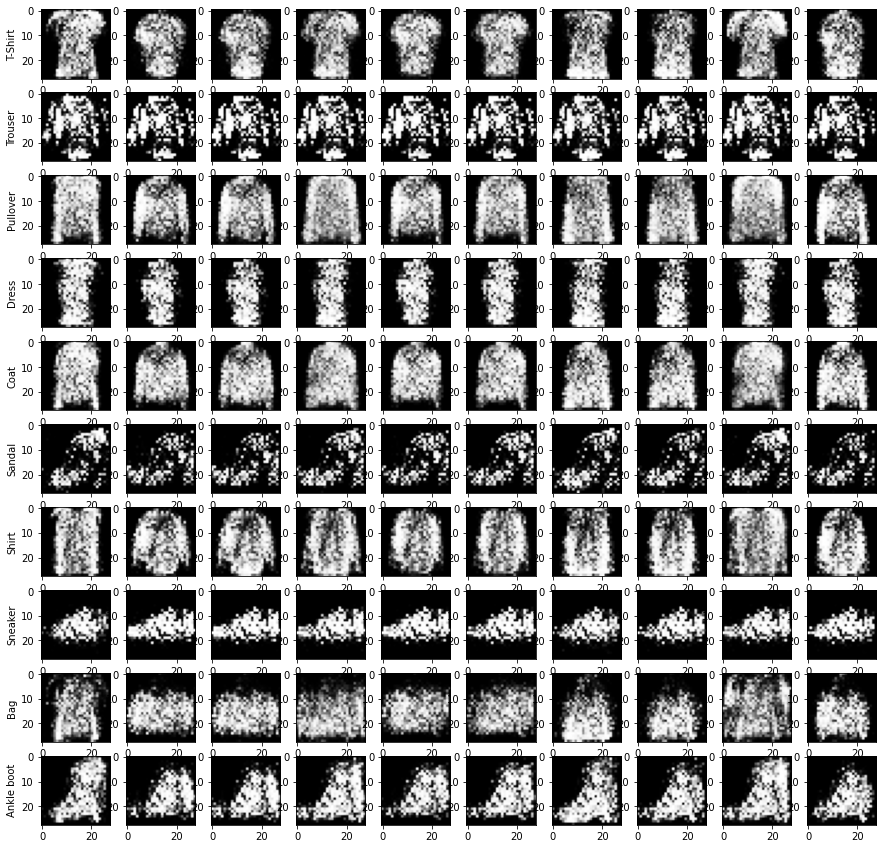

In [0]:
noise.data.normal_(0, 1)
sample_images = []
fig, ax = plt.subplots(figsize=(15,15))
k = 1
for m in range(10):
  labels = Variable(torch.LongTensor(m*np.ones(16).astype(int)))
  sample_images.append(generator(noise, labels))
  
tics = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for m in range(10):
  for j in range(10):
    plt.subplot(10, 10, k)
    plt.imshow(sample_images[m][j].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    if k % 10 == 1:
      plt.ylabel(tics[k // 10])
    k += 1

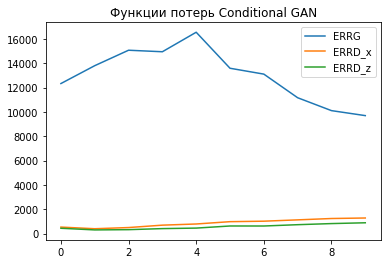

In [0]:
plt.plot(ERRG, label = "ERRG")
plt.plot(ERRD_x, label = "ERRD_x")
plt.plot(ERRD_z, label = "ERRD_z")
plt.legend()
plt.title("Функции потерь Conditional GAN")
plt.show()